In [1]:
%matplotlib inline
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, KBinsDiscretizer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.pipeline import Pipeline

import custom_helpers as ch

np.random.seed(0)

In [2]:
df = ch.load_data('../data/train_month_3_with_target.csv')
print(df.info())

------------------------------------------------------------
loading data...
transforming dates...
cast types into bool, object, categorical...
data loaded and casted
------------------------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63697 entries, 0 to 63696
Data columns (total 43 columns):
 #   Column                             Non-Null Count  Dtype         
---  ------                             --------------  -----         
 0   client_id                          63697 non-null  object        
 1   homebanking_active                 63697 non-null  bool          
 2   has_homebanking                    63697 non-null  bool          
 3   has_insurance_21                   63697 non-null  bool          
 4   has_insurance_23                   63697 non-null  bool          
 5   has_life_insurance_fixed_cap       63697 non-null  bool          
 6   has_life_insurance_decreasing_cap  63697 non-null  bool          
 7   has_fire_car_other_

In [3]:
#non sample-dependent transformations
def sample_agnostic_transformation(data):
    
    # num_col = data.select_dtypes(include = 'number', exclude = 'bool').columns
    # for col in num_col:
    #     data[col] = data[col].fillna(value = np.nan)
    
    selected_col = [
            'homebanking_active'
              ,'has_homebanking'
              ,'bal_mortgage_loan'
              ,'has_life_insurance_decreasing_cap'
              ,'has_mortgage_loan'
              ,'has_current_account'
              ,'cap_life_insurance_decreasing_cap'
              ,'bal_savings_account'
              ,'bal_current_account'
              ,'has_personal_loan'
              ,'bal_personal_loan'
              ,'customer_since_all_years'
              ,'customer_since_bank_years'
              ,'customer_age'   
         ]
    
    
    if 'target' in data.columns:
        y = data.target
        X = data.drop(columns = ['target'])
        X = X[selected_col]
    else:
        X = data[selected_col]
        y = 0
        
    return X, y

X, y = sample_agnostic_transformation(df)

In [4]:
# sample dependent column specific preprocessing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)


num_col = X_train.select_dtypes(include = 'number', exclude = 'bool').columns
cat_col = X_train.select_dtypes(include = 'category').columns
bool_col = X_train.select_dtypes(include = 'bool').columns
date_col = X_train.select_dtypes(include = 'datetime64').columns
obj_col = X_train.select_dtypes(include = 'object').columns

In [5]:
from sklearn.preprocessing import FunctionTransformer, KBinsDiscretizer

numeric_transformer = Pipeline(steps = [
    ('impute',SimpleImputer(missing_values=np.nan, strategy='median')),
    ('scale', StandardScaler())
])

categorical_transformer = OneHotEncoder(drop = 'first',handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
        ('drop_ID','drop',obj_col),
        ('drop_dates','drop',date_col),
        ('cat',categorical_transformer,cat_col),
        ('num',numeric_transformer,num_col)
    ],
    remainder = "passthrough"
)

f = preprocessor.fit_transform(X_train)
f = pd.DataFrame(f)

In [6]:
# FIRST ROUND TEST

lr = LogisticRegression(class_weight = 'balanced')
# lr = LogisticRegression()

#pipeline
pipe = Pipeline(
    steps=[("preprocessor", preprocessor),("classifier", lr)]
)


# train 
clf = pipe.fit(X_train,y_train)

# make prediction on test
y_pred_test = clf.predict(X_test)
y_pred_test_probs = clf.predict_proba(X_test)

ch.evaluate(y_test, y_pred_test, y_pred_test_probs)

------------------------------------------------------------
Performance Over Whole Set
------------------------------------------------------------
               precision    recall  f1-score   support

Did not Churn       0.98      0.67      0.80     30889
        Churn       0.06      0.65      0.11       960

     accuracy                           0.67     31849
    macro avg       0.52      0.66      0.45     31849
 weighted avg       0.96      0.67      0.78     31849

AUC: 0.66 

------------------------------------------------------------
No. of TP (precision@250): 44
AUC: 0.500
------------------------------------------------------------


LogisticRegression()
------------------------------------------------------------
Performance Over Whole Set
------------------------------------------------------------
               precision    recall  f1-score   support

Did not Churn       0.97      1.00      0.98     30889
        Churn       0.00      0.00      0.00       960

     accuracy                           0.97     31849
    macro avg       0.48      0.50      0.49     31849
 weighted avg       0.94      0.97      0.96     31849

AUC: 0.50 

------------------------------------------------------------
No. of TP (precision@250): 0
AUC: 0.498
------------------------------------------------------------


LogisticRegression(class_weight='balanced')
------------------------------------------------------------
Performance Over Whole Set
------------------------------------------------------------
               precision    recall  f1-score   support

Did not Churn       0.98      0.67      0.80     30889
        Churn    

<Figure size 432x288 with 0 Axes>

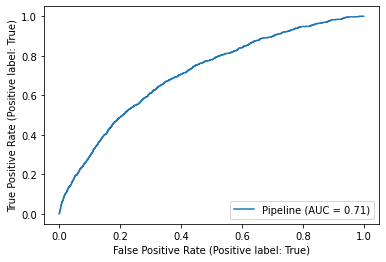

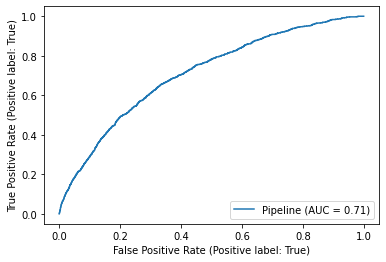

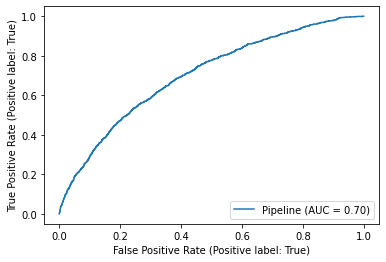

In [7]:
from sklearn.metrics import RocCurveDisplay
lr_nob = LogisticRegression()
lr = LogisticRegression(class_weight = 'balanced')
lrcv_5 = LogisticRegressionCV(cv = 5, random_state=0, class_weight = 'balanced' )
lrcv_10 = LogisticRegressionCV(cv = 10, random_state=0, class_weight = 'balanced')

models = [lr_nob,lr,lrcv_5]
plt.figure()
for model in models:
    pipe = Pipeline(
    steps=[("preprocessor", preprocessor),("classifier", model)]
    )

    # train 
    clf = pipe.fit(X_train,y_train)
    
    ax = RocCurveDisplay.from_estimator(clf, X_test, y_test)

    # make prediction on test
    y_pred_test = clf.predict(X_test)
    y_pred_test_probs = clf.predict_proba(X_test)
    
    print(model)
    ch.evaluate(y_test, y_pred_test, y_pred_test_probs)
    print('\n')


In [8]:
# # run on submission data
# data_sub = pd.read_csv('../data/test_month_3.csv',parse_dates = [29,30,32], index_col = 'client_id')
# X_sub, y_sub = sample_agnostic_transformation(data_sub)

# #pipeline
# pipe = Pipeline(
#     steps=[("preprocessor", preprocessor),("classifier", lrcv_5)]
# )


# # train 
# clf = pipe.fit(X_train,y_train)

# # make prediction on test
# y_pred_sub = clf.predict(X_sub)
# y_pred_test_sub = clf.predict_proba(X_sub)
# y_pred_test_sub_pos = [x[1] for x in y_pred_test_sub]

# df = pd.DataFrame({'ID': X_sub.index,'PROB':y_pred_test_sub_pos})
# today
# df.to_csv(f'../output/lr_{today.month}{today.day}.csv', index = False)